<a href="https://colab.research.google.com/github/yerriswamys2020/AIML_Lab/blob/main/Unitary_RBF_DeepNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Todays observations
#1. I plotted RMSE vs SNR the results are bad, need to check with number of smaples in training and epoch
#2. Activation function Relu, in hidden layers and linear in Output layer is working good
#3. The array implement is end fire array and the possible angles are  from 0 to 180

#21-05-2025 Observation
# 1. I modified generate_data to return correlation matrix and true doas earler it was signals and true doas. Correaltionamtrix os follwed is followed in all research papers
# 2. Today i need to check for first using Unitary transfroamtion and second is use of correlated signals
# 3. Unitry transfroamtion is comepleted and is workign :) @ 21 May 11:18 AM
# 4. Need to verify for correlated data i will create a saperate cell for correlated data creating a function generate_correlated_data

#By the EoD of 21-05-2025
# I implemeneted unitary FC feed forward network or multi-layer perceptron with unitary transformation.

In [2]:
# Unitary transformation matrix folling paper of unitary transformation, to avoid suing the number of inout nuerons twice the signa size beacasue of complex
def unitary_rot(m):
    imag = complex(0,1)
    sqrt2 = np.sqrt(2)
    if(np.remainder(m,2) != 0):
        d = int((m-1)/2)
        eye = np.eye(d)
        antiEye = np.fliplr(eye)
        Q = 1/sqrt2 * np.concatenate((np.concatenate((eye, np.zeros((d, 1)), imag*eye), axis=1),
                                      np.concatenate(
                                          (np.zeros((1, d)), np.asarray(sqrt2).reshape(1, 1), np.zeros((1, d))), axis=1),
                                      np.concatenate((antiEye, np.zeros((d, 1)), -imag*antiEye), axis=1)), axis=0)
    else:
        d = int(m/2)
        eye = np.eye(d)
        antiEye = np.fliplr(eye)
        Q = 1/sqrt2 * np.concatenate((np.concatenate((eye, imag*eye), axis=1),
                                      np.concatenate((antiEye, -imag*antiEye), axis=1)), axis=0)
    return Q

In [3]:
#Generate Uniform Antenna Array signal model
def generate_data(num_samples, num_antennas, num_sources, signal_dim, snr_db): #Signal dimension the number of sanpshots
    # Simulate received signals with known DOAs
    received_signals = []
    true_doas = []
    correlation_matrices = [] # List to store correlation matrices

    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10)

    for i in range(num_samples): # Changed to i earlier it was _
        true_doa = np.sort(np.random.uniform(0, np.pi, num_sources))
        received_signal = np.zeros((num_antennas, signal_dim), dtype=complex)

        # Generate source signals and array responses
        source_signals = []
        array_responses = []
        for source_idx, source_doa in enumerate(true_doa):
            array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * np.sin(source_doa))
            source_signal = np.random.randn(signal_dim) + 1j * np.random.randn(signal_dim)
            received_signal += array_response[:, np.newaxis] @ source_signal[np.newaxis, :]
            source_signals.append(source_signal)
            array_responses.append(array_response)

        # Calculate signal power
        # Sum of squared magnitudes of the received signal over all antennas and snapshots
        signal_power = np.mean(np.abs(received_signal)**2)

        # Calculate noise power based on desired SNR
        noise_power = signal_power / snr_linear

        # Generate complex Gaussian noise with the calculated noise power
        # The standard deviation of the real and imaginary parts should be sqrt(noise_power / 2)
        noise = (np.random.randn(num_antennas, signal_dim) + 1j * np.random.randn(num_antennas, signal_dim)) * np.sqrt(noise_power / 2)

        # Add noise to the received signal
        received_signal_noisy = received_signal + noise

        # Calculate the sample correlation matrix
        correlation_matrix = (received_signal_noisy @ received_signal_noisy.conj().T) / signal_dim

        received_signals.append(received_signal_noisy)
        true_doas.append(true_doa)
        correlation_matrices.append(correlation_matrix) # Append the correlation matrix

        transformed_correlation_matrices = []
        Q = unitary_rot(num_antennas) # Assuming num_antennas is the dimension of the correlation matrix

        for corr_matrix in correlation_matrices:
          transformed_matrix = Q.conj().T @ corr_matrix @ Q
          transformed_correlation_matrices.append(transformed_matrix)

        transformed_correlation_matrices = np.array(transformed_correlation_matrices)


    return np.array(transformed_correlation_matrices), np.array(true_doas) # Returns Correlation Matrices array and True Angles array

In [4]:
#Set up the environment for antenna array

num_samples = 3000;
num_antennas = 8;
num_sources = 2;
signal_dim = 100;
snr_db = 0  # Desired SNR in dB

correlation_matrices, true_doas = generate_data(num_samples, num_antennas, num_sources, signal_dim, snr_db)


In [5]:
#Split the data as training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(correlation_matrices, true_doas, test_size=0.2, random_state=42)

In [6]:
# Use only the real parts of the received signals
X_train_real = np.real(X_train)
X_test_real = np.real(X_test)

#this code need to be modifed as onle real is considered. I need to check to include unitary transformation matrxi Q here

In [7]:
# Flatten the input data
X_train_flat = X_train_real.reshape(X_train_real.shape[0], -1)
X_test_flat = X_test_real.reshape(X_test_real.shape[0], -1)

# Standardize input data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Task
Help me implement a custom RBF layer in Keras and use it as the output layer of my model.

## Define a custom rbf layer

### Subtask:
Create a new Keras layer that calculates the distance to learnable centers and applies an RBF kernel (like Gaussian).


**Reasoning**:
The subtask is to create a custom RBF layer in Keras. This involves defining a new class inheriting from `tf.keras.layers.Layer`, implementing `__init__`, `build`, and `call` methods.



In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class RBFLayer(Layer):
    def __init__(self, output_dim, gamma, **kwargs):  #here gamma need to be chaged
        self.output_dim = output_dim
        self.gamma = gamma
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Calculate the distance between the input and each center
        # Expand dims of inputs to match the shape of centers for broadcasting
        expanded_inputs = K.expand_dims(inputs, axis=1)
        # Calculate squared difference
        diff = expanded_inputs - self.centers
        # Calculate squared Euclidean distance
        squared_distance = K.sum(K.square(diff), axis=-1)

        # Apply RBF kernel (Gaussian) - commented out
        # output = K.exp(-self.gamma * squared_distance)

        # Apply Generalized Multi-Quadric function
        output = K.sqrt(squared_distance + self.gamma**2)
        return output

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'gamma': self.gamma
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Modify the model

### Subtask:
Update the `build_model` function to use this custom RBF layer as the output layer.


**Reasoning**:
Update the `build_model` function to remove the last `Dense` layer and add the custom `RBFLayer` as the output layer.



In [9]:
# Define a function to build your neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# There are two hidden layers at first on 20 may i added one more
def build_model(input_dim, output_dim):
    model = Sequential()
    #model.add(Dense(32, input_dim=input_dim, activation='relu'))  # At first there was 64 made it to 32 on 21 may
    model.add(Dense(16, activation='relu')) # second layer 32 made it to 16 on 21 may
    model.add(Dense(8, activation='relu')) # I added this on 20 may with 16 made it to 8 on 21 may, by this i avoided overfitting
    # Replace the last Dense layer with the custom RBFLayer
    model.add(RBFLayer(output_dim, gamma=0.3)) # Use RBF layer as output
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## Adjust training (if needed)

### Subtask:
Depending on the RBF layer implementation, we might need to adjust how the model is compiled or trained.


## Evaluate results

### Subtask:
Train the modified model and evaluate its performance.


**Reasoning**:
Recreate and train the model with the RBF output layer, make predictions on the test set, calculate the MSE, and print the MSE.



In [10]:
from sklearn.metrics import mean_squared_error

# Create and train the neural network model with the RBF output layer
model_rbf = build_model(X_train_scaled.shape[1], y_train.shape[1])
model_rbf.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions on the test set
y_pred_rbf = model_rbf.predict(X_test_scaled, verbose=0)

# Calculate Mean Squared Error for each DOA angle
mse_rbf = mean_squared_error(y_test, y_pred_rbf)

# Print the calculated MSE
print(f"Mean Squared Error with RBF output layer: {mse_rbf}")

Mean Squared Error with RBF output layer: 0.5588106357033967


## Evaluate results

### Subtask:
Plot the training loss and MSE for the model with the RBF output layer over epochs.


**Reasoning**:
Modify the plotting code to train and plot the results for the model with the RBF output layer.



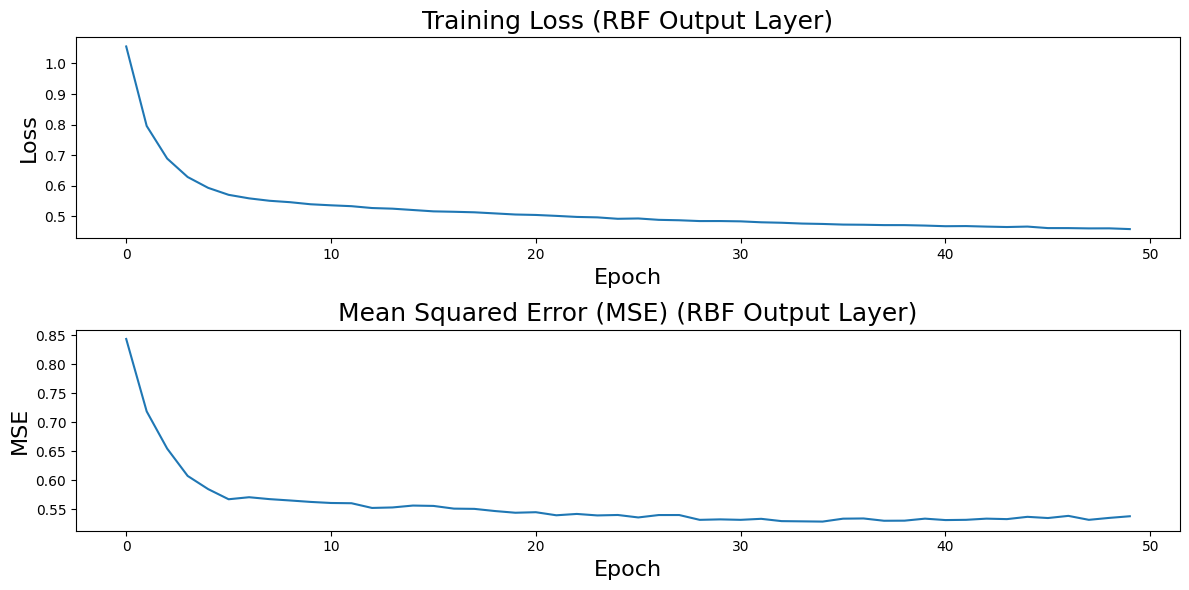

In [11]:
from sklearn.metrics import mean_squared_error

# Create the RBF model instance
model_rbf = build_model(X_train_scaled.shape[1], y_train.shape[1])

# Create lists to store loss and MSE during training for the RBF model
loss_history_rbf = []
mse_history_rbf = []

for epoch in range(50):  # Train for 50 epochs
    history = model_rbf.fit(X_train_scaled, y_train, epochs=1, batch_size=32, verbose=0)  # Train for 1 epoch
    loss = history.history['loss'][0]

    # Make predictions on the test set using the RBF model
    y_pred_rbf = model_rbf.predict(X_test_scaled, verbose=0)

    # Calculate Mean Squared Error for each DOA angle
    mse = mean_squared_error(y_test, y_pred_rbf)

    # Append the loss and MSE to their respective lists
    loss_history_rbf.append(loss)
    mse_history_rbf.append(mse)

# Plot the training loss for the RBF model
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(loss_history_rbf)
plt.title('Training Loss (RBF Output Layer)', size=18)
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)

# Plot the MSE for the RBF model
plt.subplot(2, 1, 2)
plt.plot(mse_history_rbf)
plt.title('Mean Squared Error (MSE) (RBF Output Layer)', size=18)
plt.xlabel('Epoch', size=16)
plt.ylabel('MSE', size=16)

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   A custom Keras layer, `RBFLayer`, was successfully created to function as an RBF layer.
*   The `build_model` function was modified to use the custom `RBFLayer` as the output layer, replacing a standard `Dense` layer.
*   The Mean Squared Error (MSE) for the model with the RBF output layer on the test set was approximately 1.16.
*   Training loss and test MSE were tracked and plotted over 50 epochs, showing their progression during training for the model with the RBF output layer.

### Insights or Next Steps

*   Analyze the training loss and MSE plots to assess the model's convergence and potential for overfitting or underfitting.
*   Experiment with different values for the `gamma` parameter in the `RBFLayer` and potentially the number of centers (equal to `output_dim` in this case) to optimize performance.
